In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import pickle
import warnings
warnings.filterwarnings('ignore')



In [2]:
# Load the dataset
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Initial data examination
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nData types and null values:")
print(df.info())
print("\nDescriptive statistics:")
print(df.describe(include='all').T)

Dataset shape: (7043, 21)

First 5 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport Streami

In [3]:
# Convert TotalCharges to numeric (it's currently stored as object)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Handle missing values - we'll impute with 0 for TotalCharges (likely new customers)
df['TotalCharges'].fillna(0, inplace=True)

# Convert Churn to binary numeric
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Drop customerID as it's not useful for modeling
df.drop('customerID', axis=1, inplace=True)

# Check class balance
print("\nChurn distribution:")
print(df['Churn'].value_counts(normalize=True))


Missing values:
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Churn distribution:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


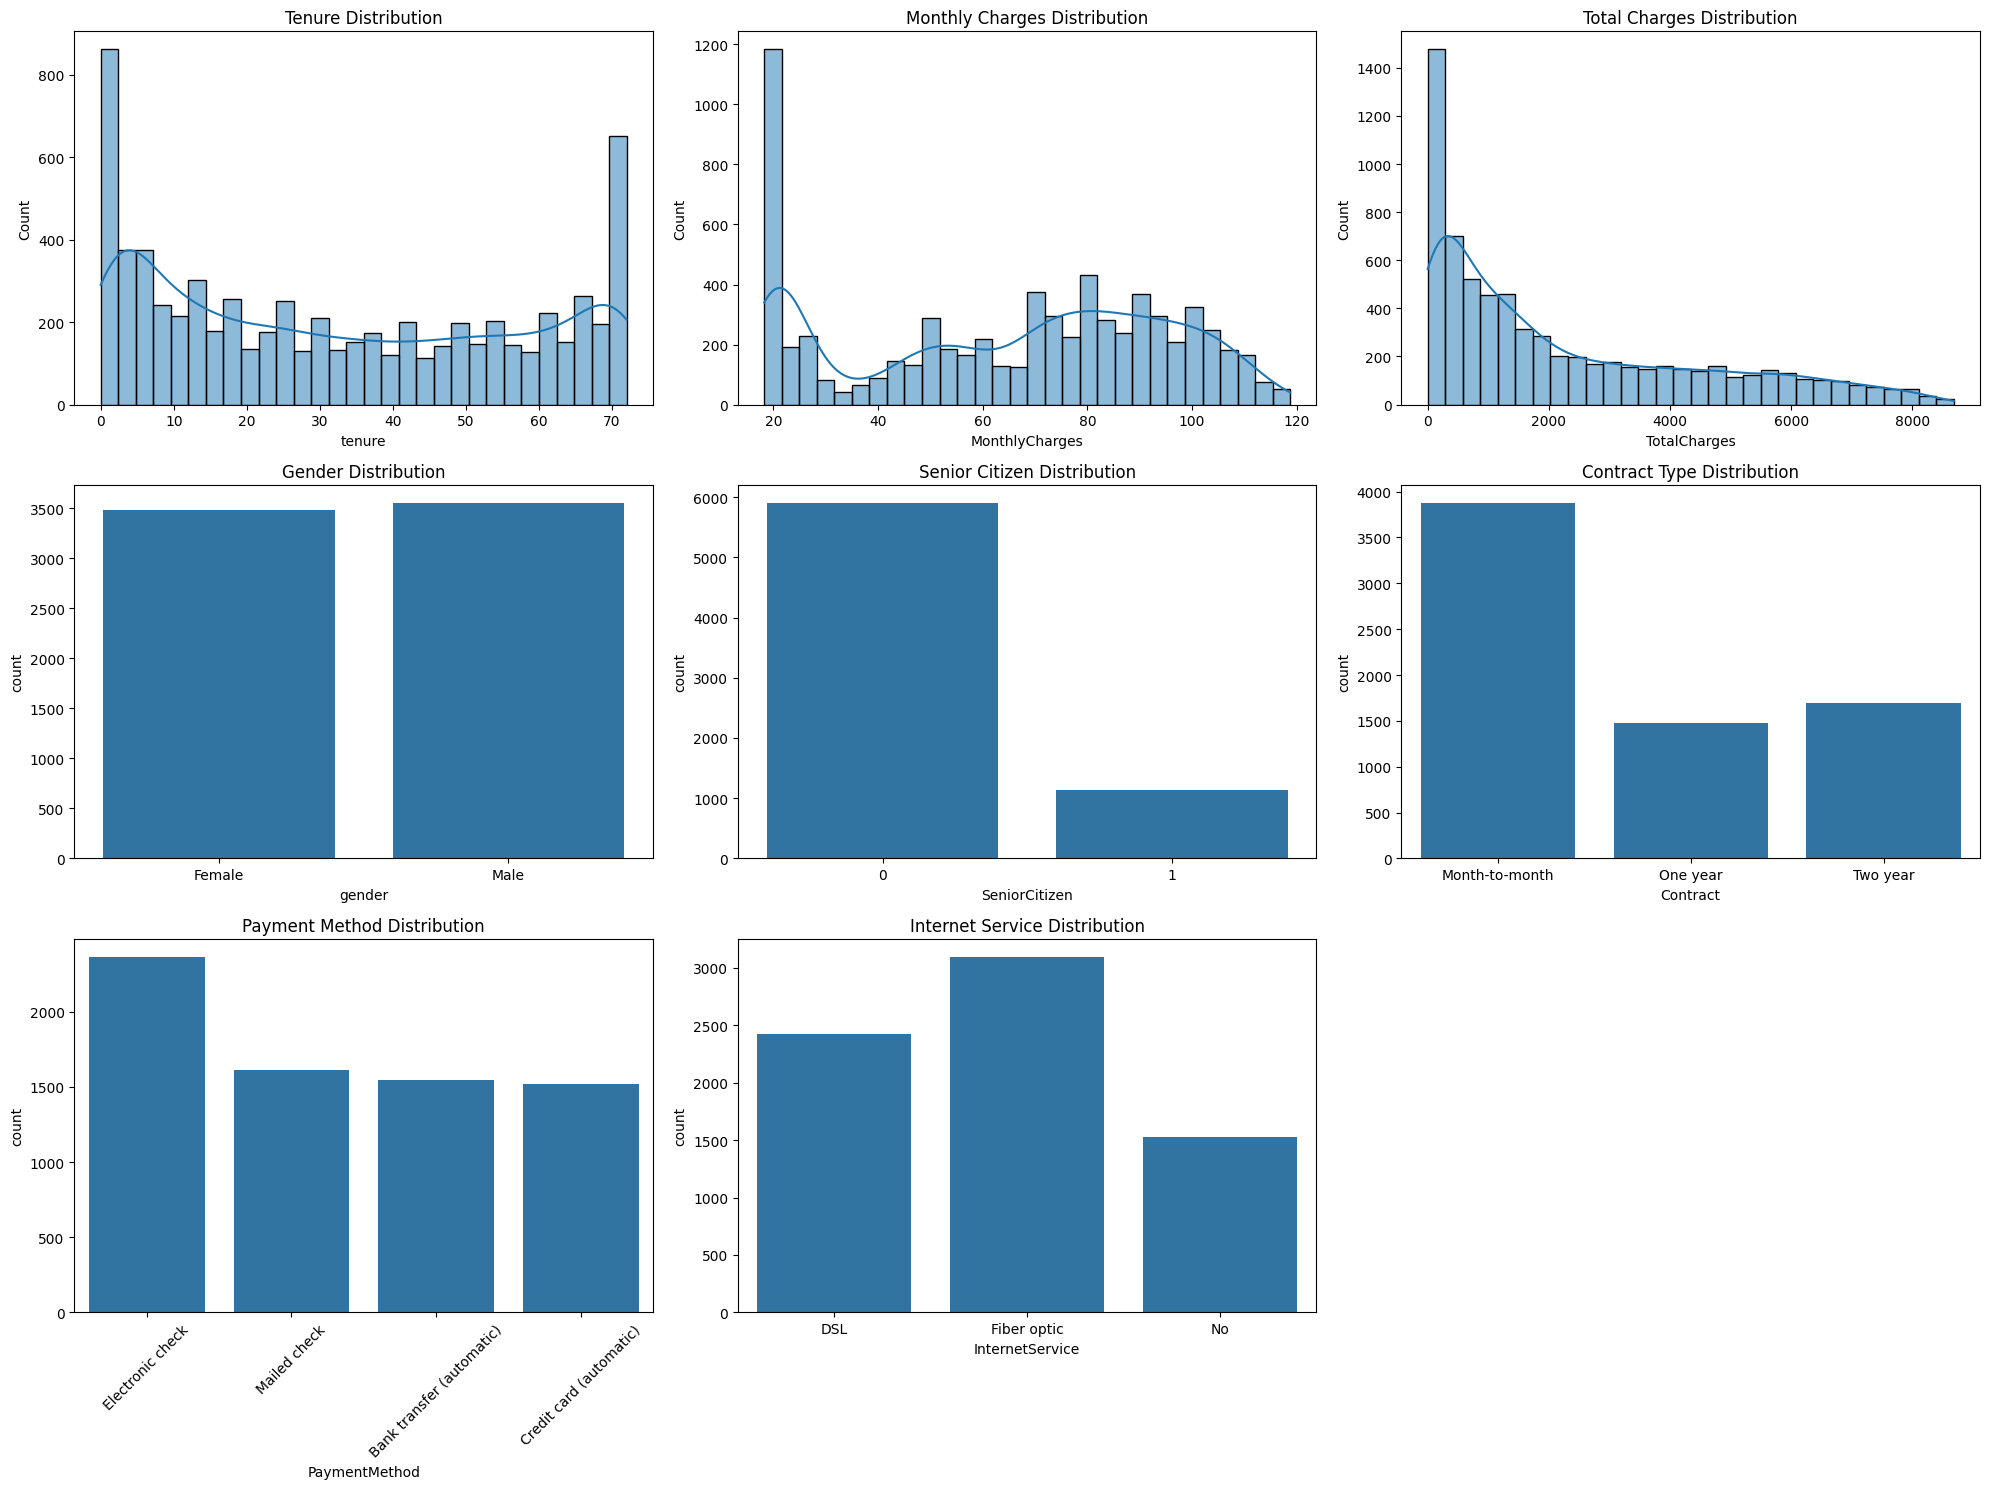

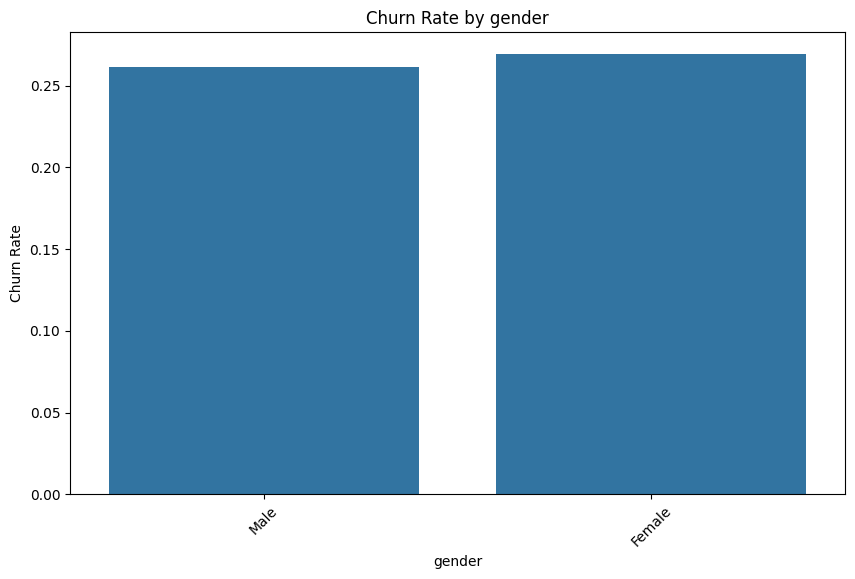

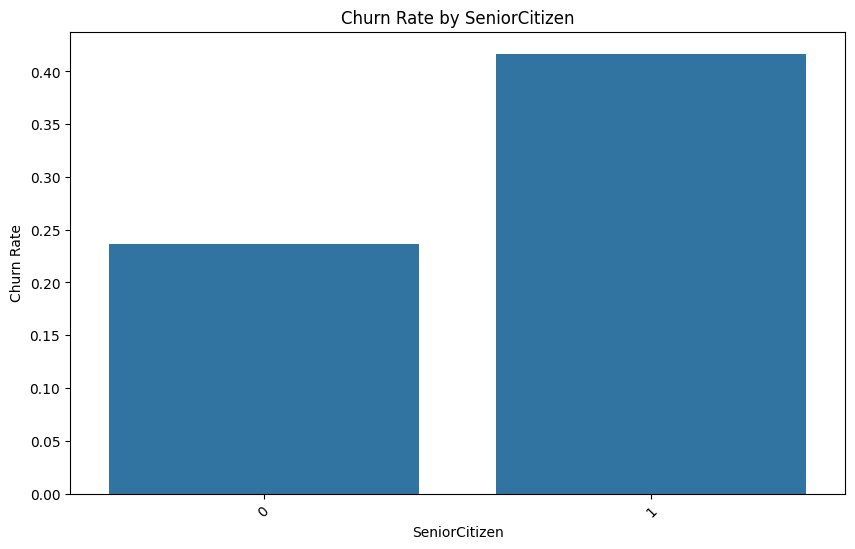

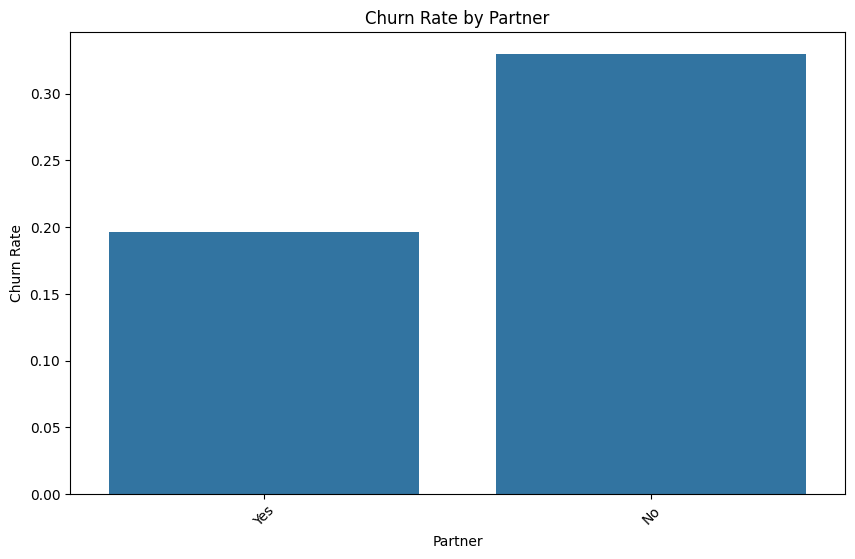

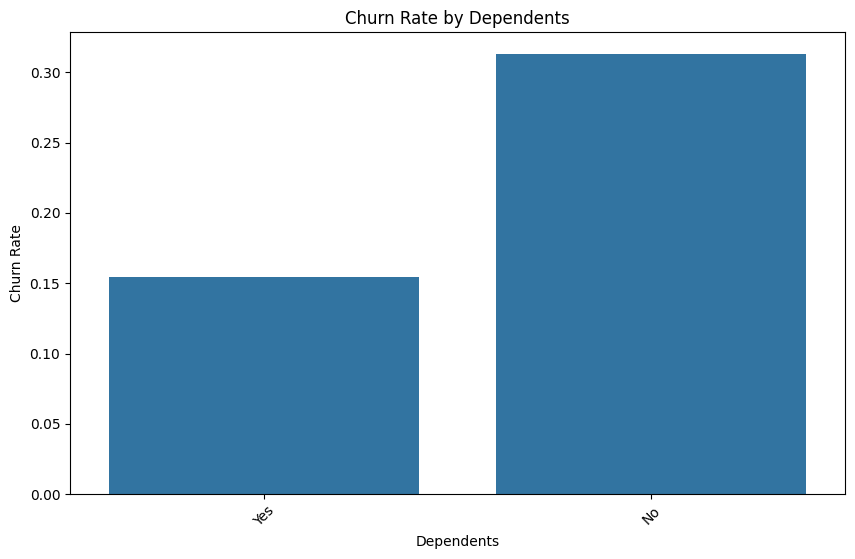

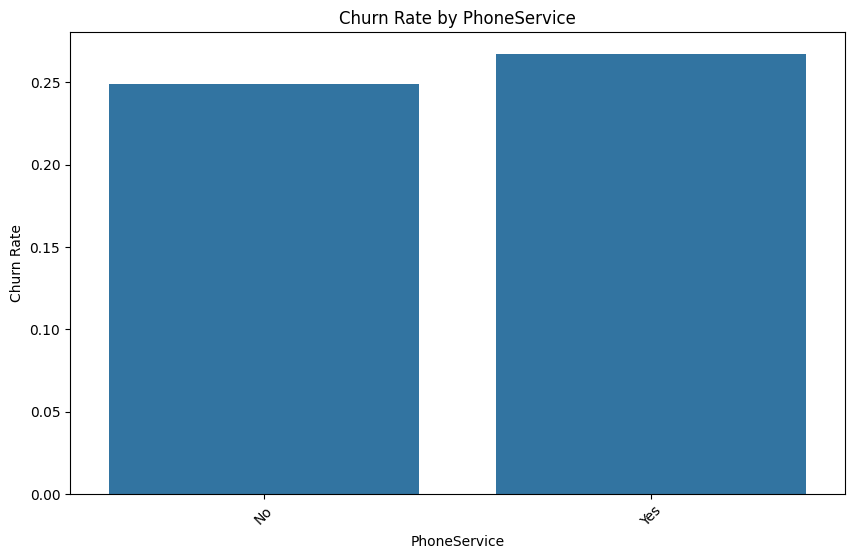

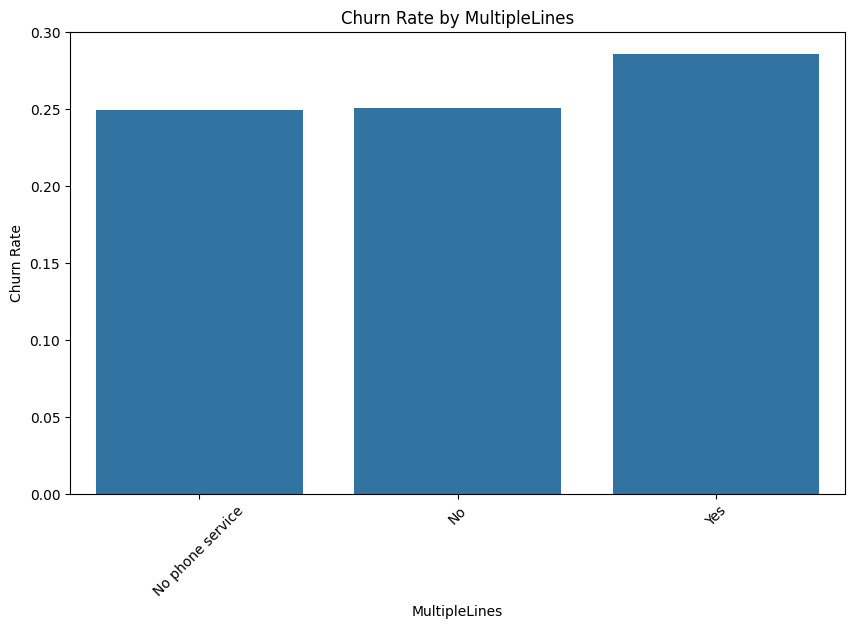

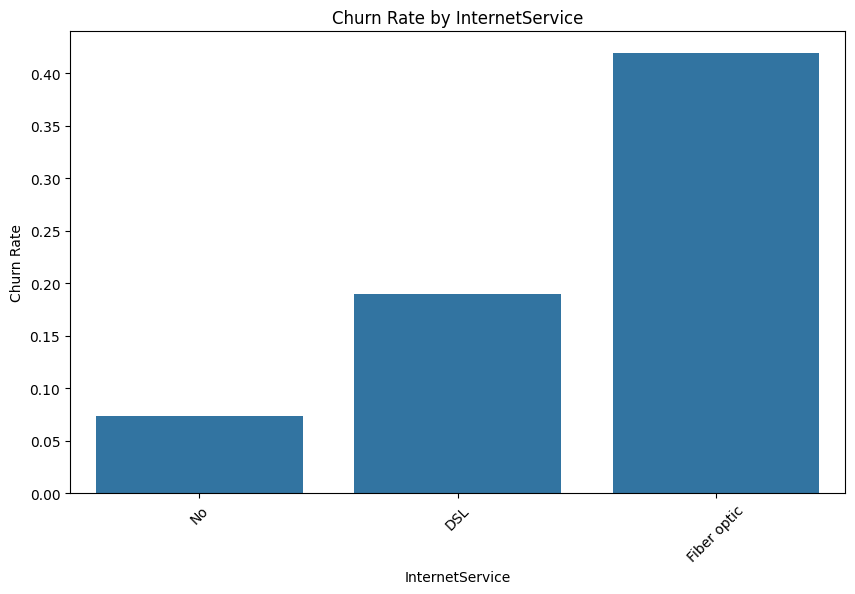

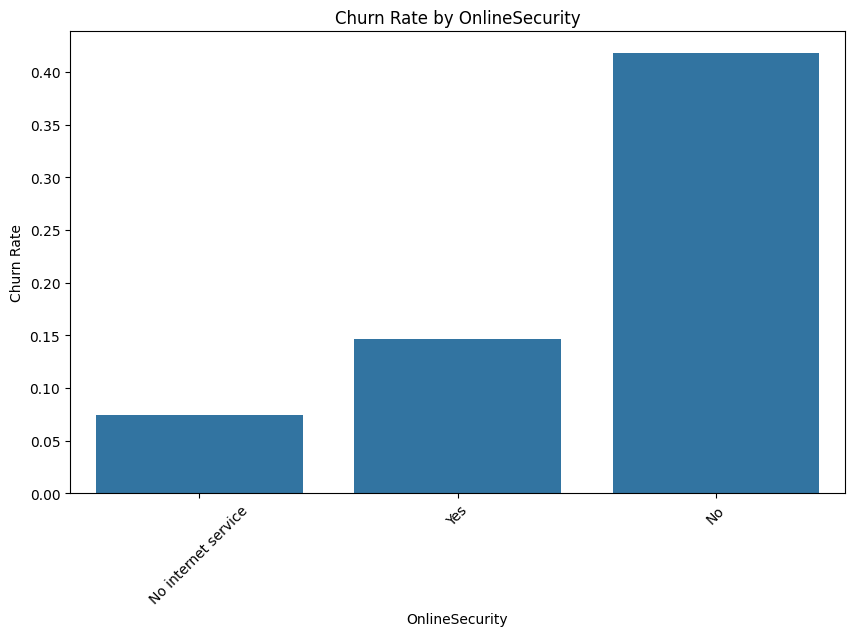

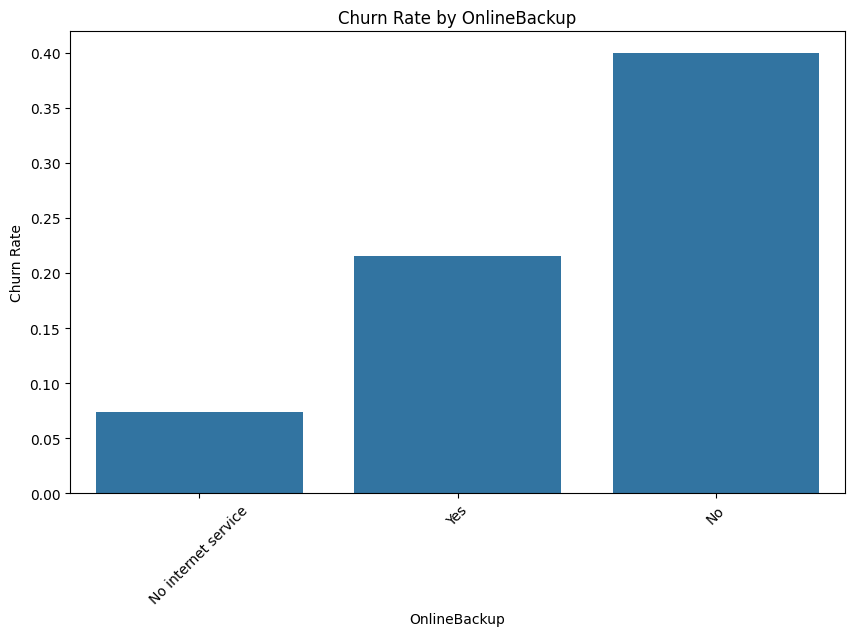

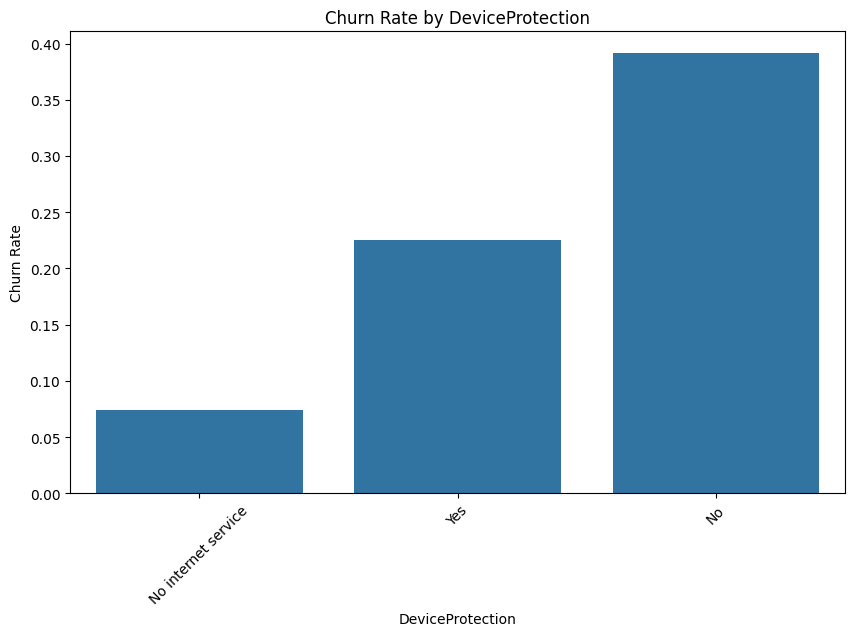

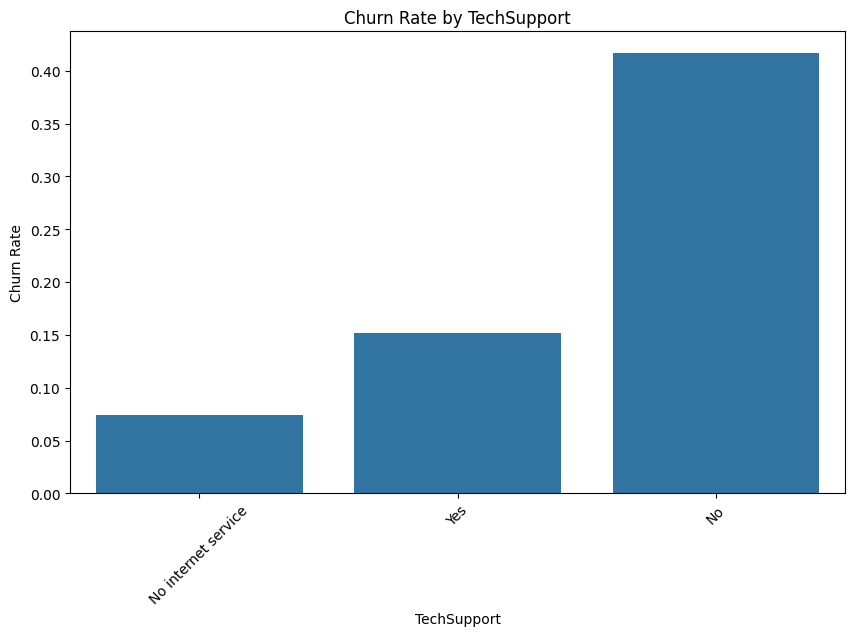

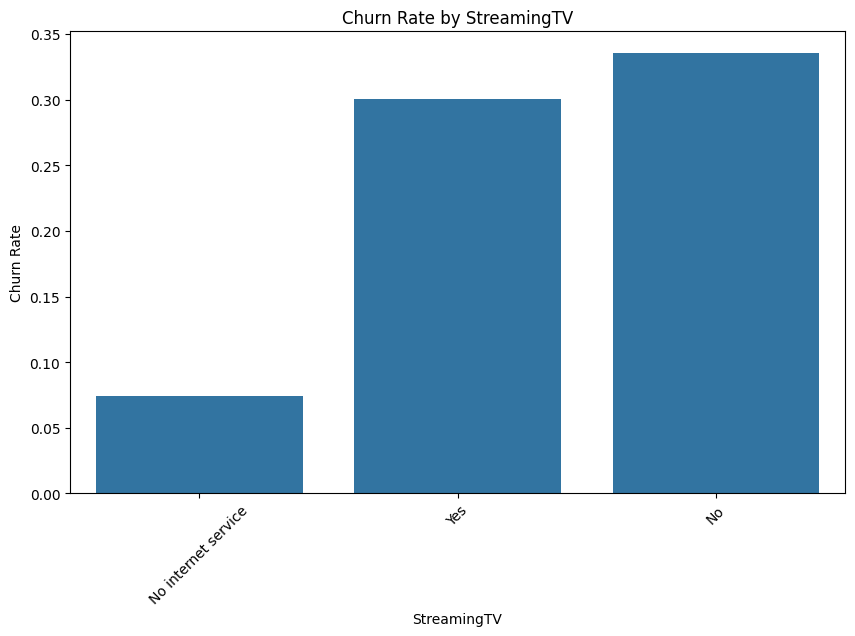

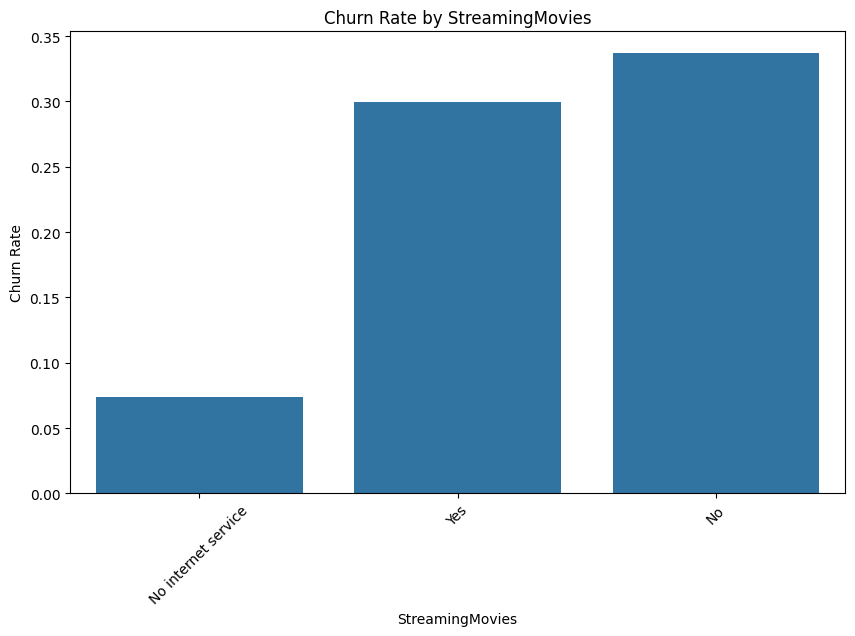

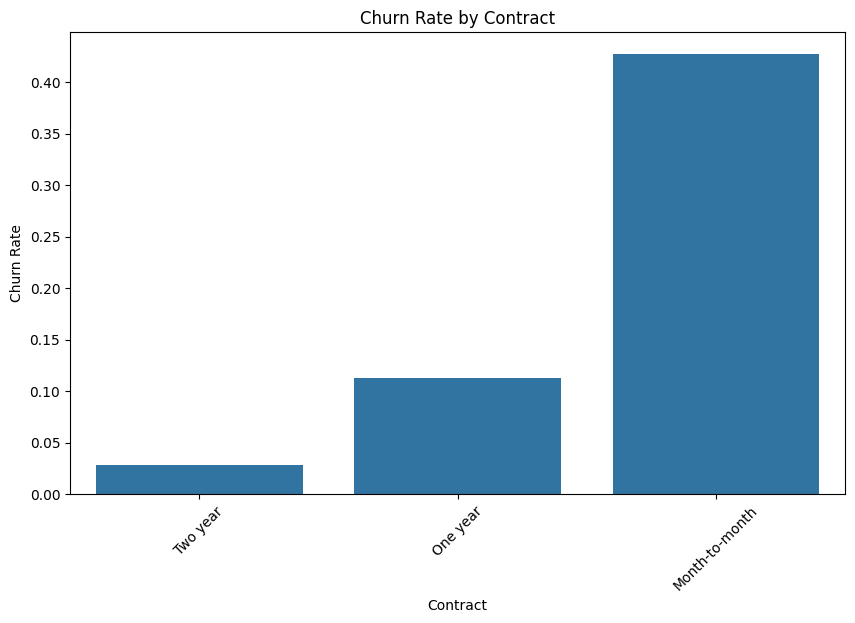

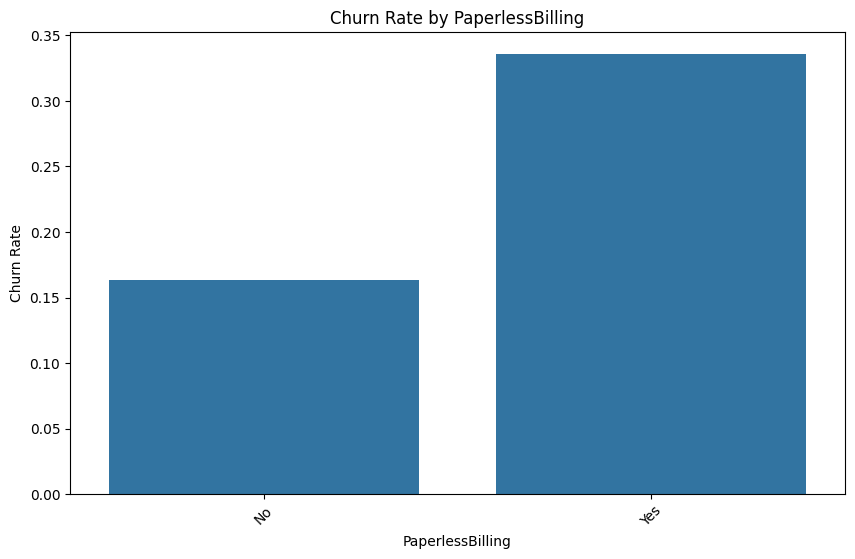

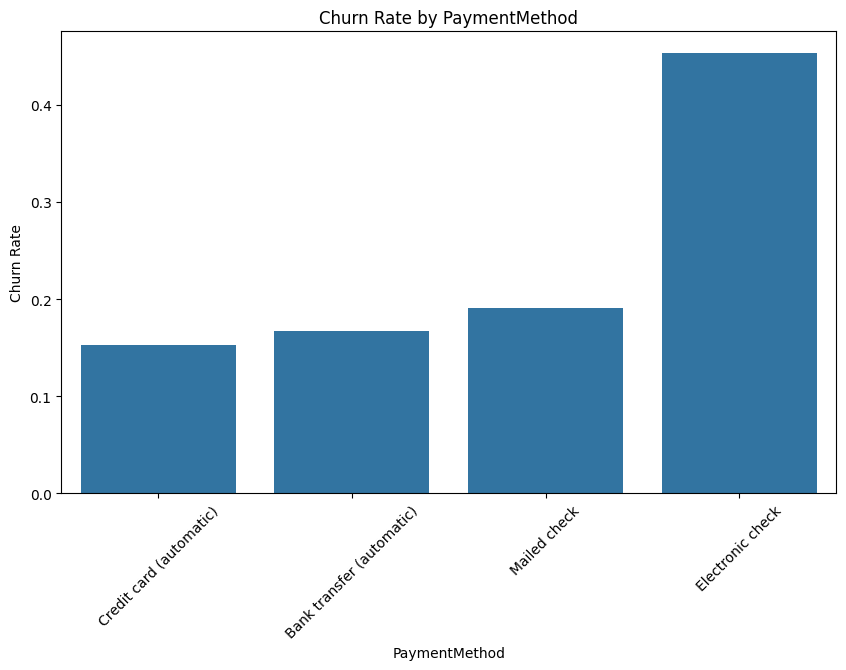

In [4]:
# Set up the figure
plt.figure(figsize=(20, 15))

# Plot distribution of numerical features
plt.subplot(3, 3, 1)
sns.histplot(df['tenure'], bins=30, kde=True)
plt.title('Tenure Distribution')

plt.subplot(3, 3, 2)
sns.histplot(df['MonthlyCharges'], bins=30, kde=True)
plt.title('Monthly Charges Distribution')

plt.subplot(3, 3, 3)
sns.histplot(df['TotalCharges'], bins=30, kde=True)
plt.title('Total Charges Distribution')

# Plot distribution of categorical features
plt.subplot(3, 3, 4)
sns.countplot(data=df, x='gender')
plt.title('Gender Distribution')

plt.subplot(3, 3, 5)
sns.countplot(data=df, x='SeniorCitizen')
plt.title('Senior Citizen Distribution')

plt.subplot(3, 3, 6)
sns.countplot(data=df, x='Contract')
plt.title('Contract Type Distribution')

plt.subplot(3, 3, 7)
sns.countplot(data=df, x='PaymentMethod')
plt.xticks(rotation=45)
plt.title('Payment Method Distribution')

plt.subplot(3, 3, 8)
sns.countplot(data=df, x='InternetService')
plt.title('Internet Service Distribution')

plt.tight_layout()
plt.show()

# Churn rate by different categories
def plot_churn_rate(categorical_col):
    plt.figure(figsize=(10, 6))
    churn_rate = df.groupby(categorical_col)['Churn'].mean().sort_values()
    sns.barplot(x=churn_rate.index, y=churn_rate.values)
    plt.title(f'Churn Rate by {categorical_col}')
    plt.ylabel('Churn Rate')
    plt.xticks(rotation=45)
    plt.show()

# Plot churn rate for important categorical features
for col in ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
            'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
            'Contract', 'PaperlessBilling', 'PaymentMethod']:
    plot_churn_rate(col)

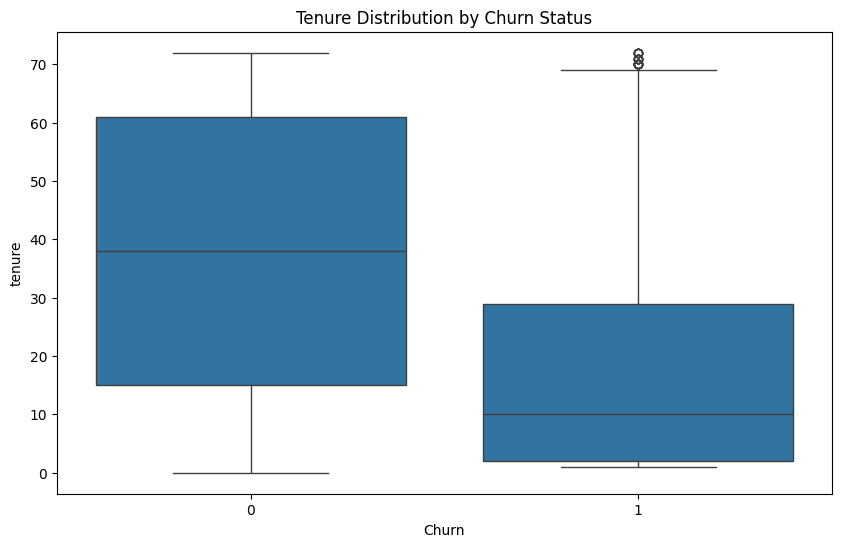

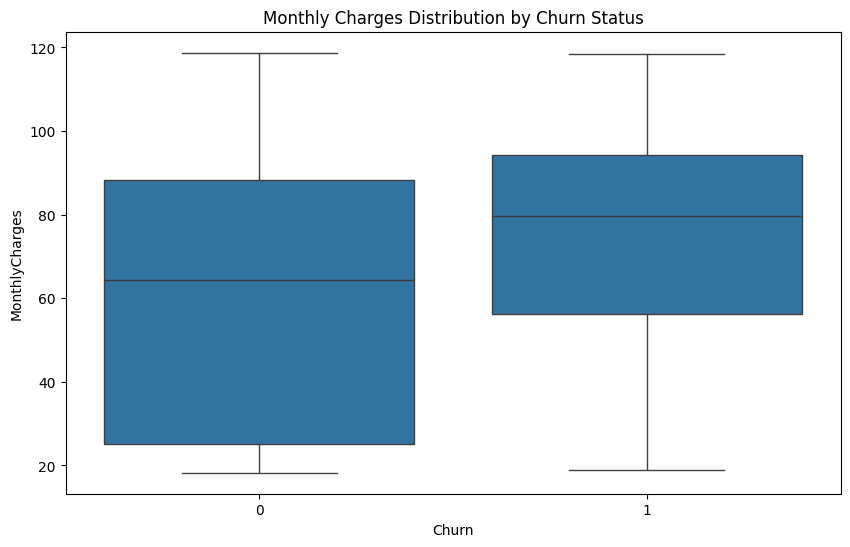

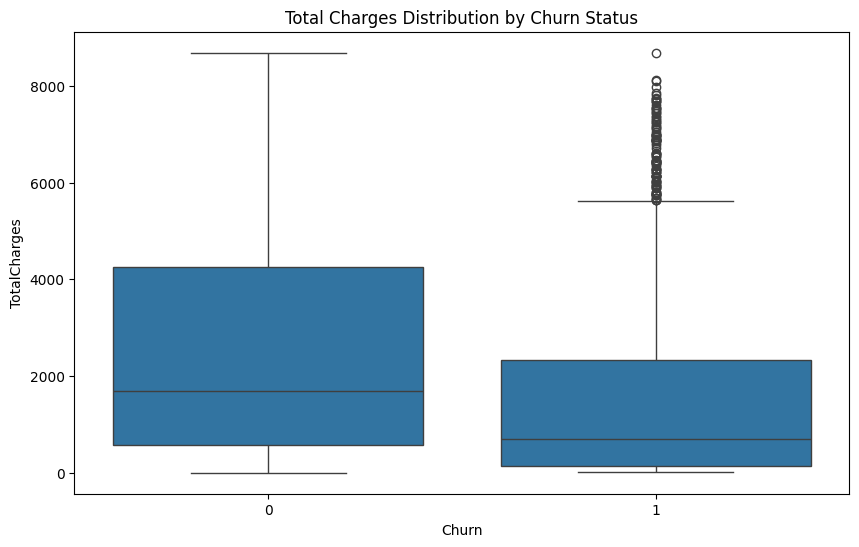

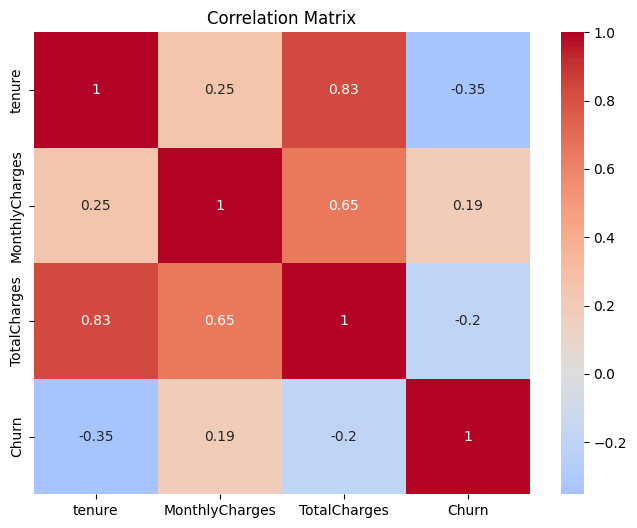

In [5]:
# Relationship between tenure and churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Tenure Distribution by Churn Status')
plt.show()

# Relationship between MonthlyCharges and churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges Distribution by Churn Status')
plt.show()

# Relationship between TotalCharges and churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='TotalCharges', data=df)
plt.title('Total Charges Distribution by Churn Status')
plt.show()

# Correlation matrix for numerical features
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
plt.figure(figsize=(8, 6))
sns.heatmap(df[numerical_features + ['Churn']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

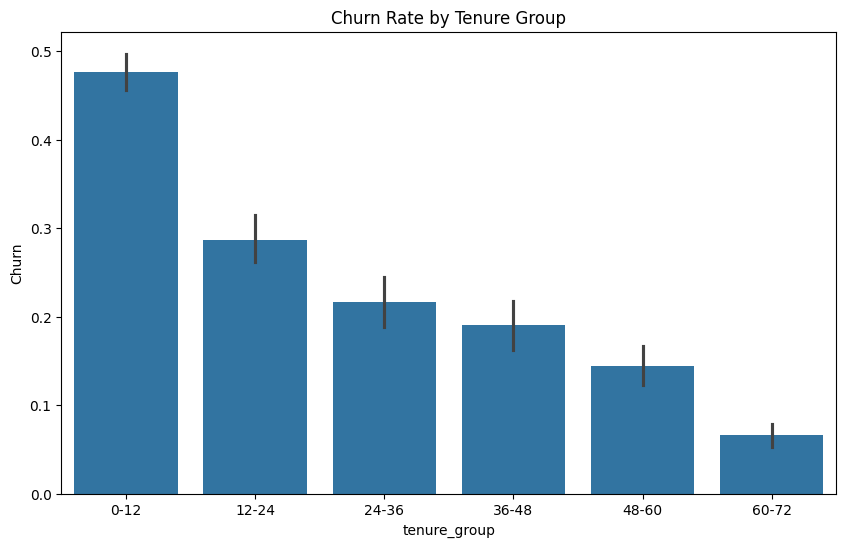

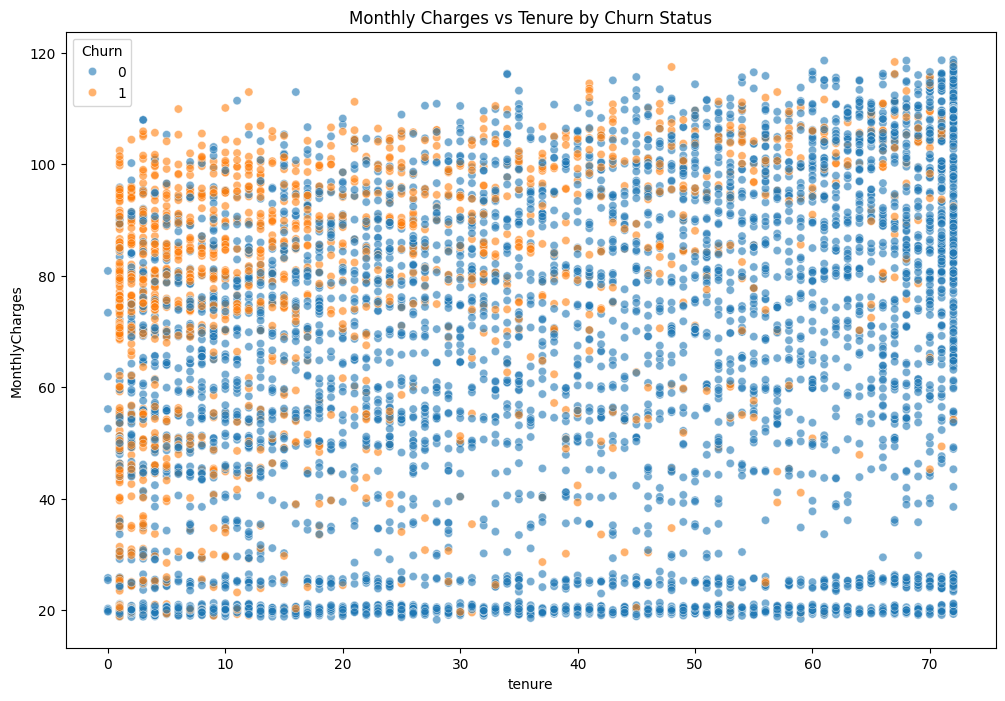

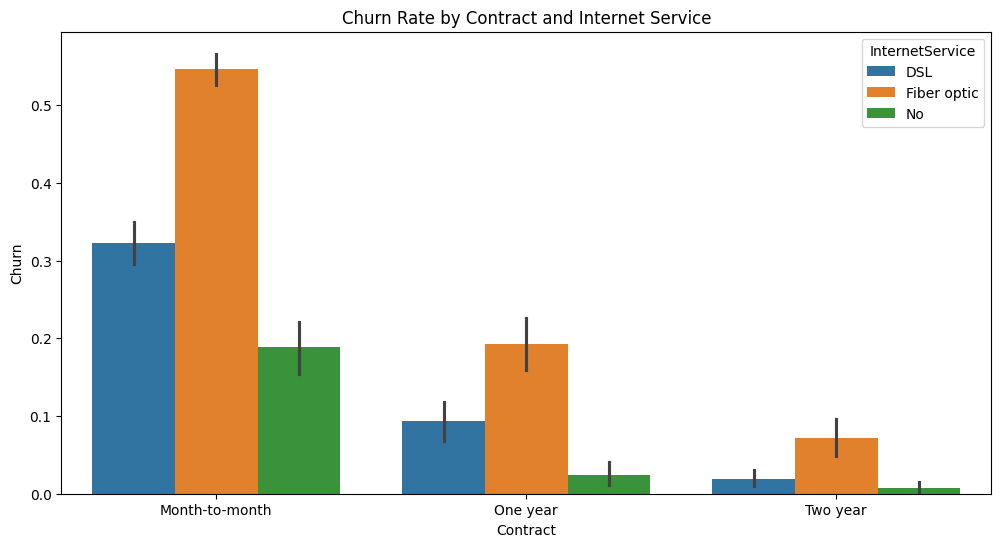

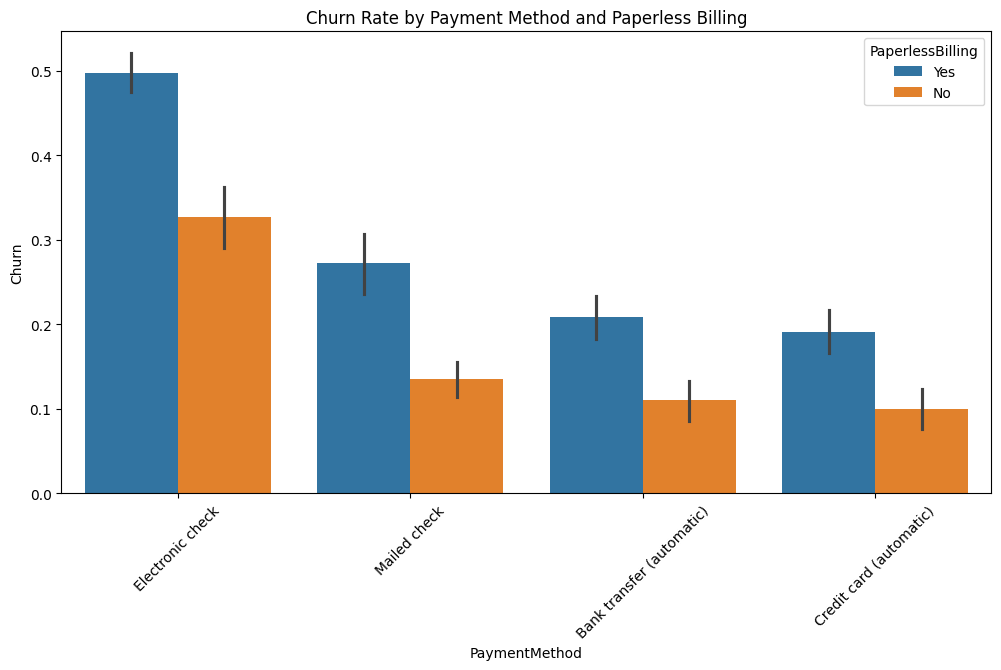

In [6]:
# Churn rate by tenure groups
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 36, 48, 60, 72],
                            labels=['0-12', '12-24', '24-36', '36-48', '48-60', '60-72'])
plt.figure(figsize=(10, 6))
sns.barplot(x='tenure_group', y='Churn', data=df)
plt.title('Churn Rate by Tenure Group')
plt.show()

# Monthly charges vs tenure colored by churn
plt.figure(figsize=(12, 8))
sns.scatterplot(x='tenure', y='MonthlyCharges', hue='Churn', data=df, alpha=0.6)
plt.title('Monthly Charges vs Tenure by Churn Status')
plt.show()

# Churn rate by contract type and internet service
plt.figure(figsize=(12, 6))
sns.barplot(x='Contract', y='Churn', hue='InternetService', data=df)
plt.title('Churn Rate by Contract and Internet Service')
plt.show()

# Churn rate by payment method and paperless billing
plt.figure(figsize=(12, 6))
sns.barplot(x='PaymentMethod', y='Churn', hue='PaperlessBilling', data=df)
plt.xticks(rotation=45)
plt.title('Churn Rate by Payment Method and Paperless Billing')
plt.show()

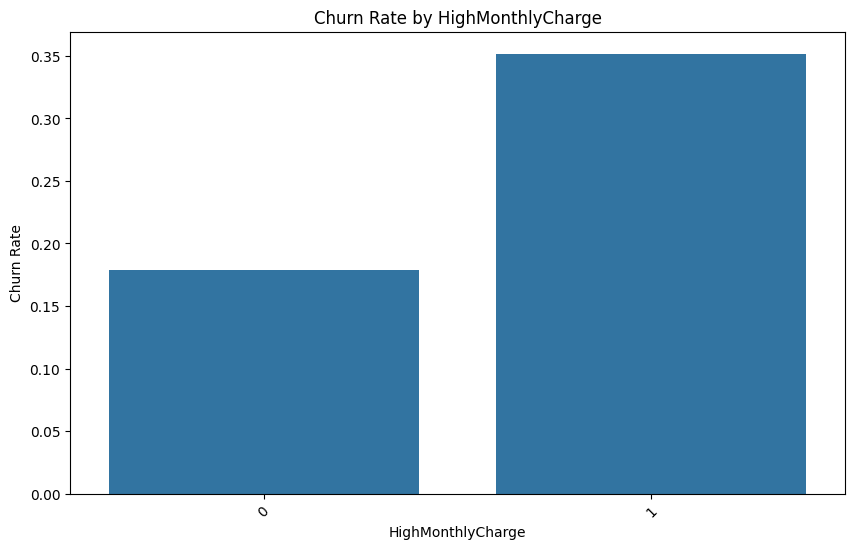

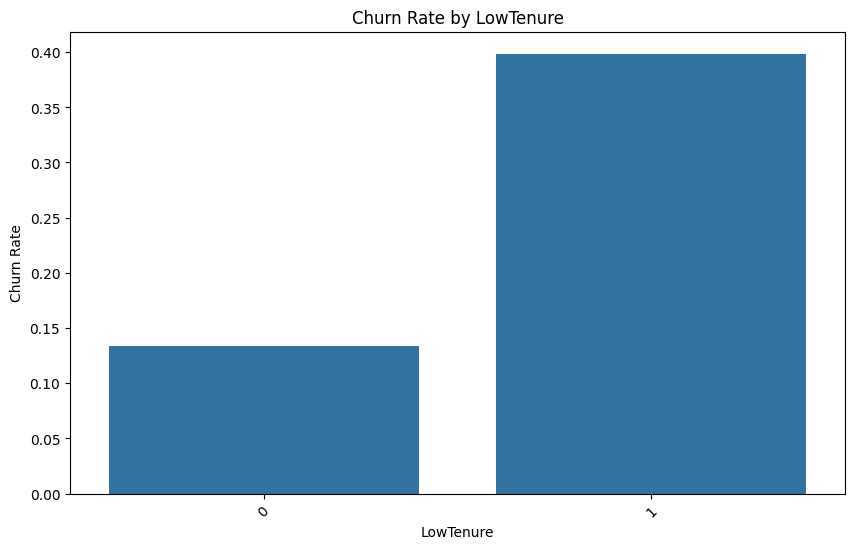

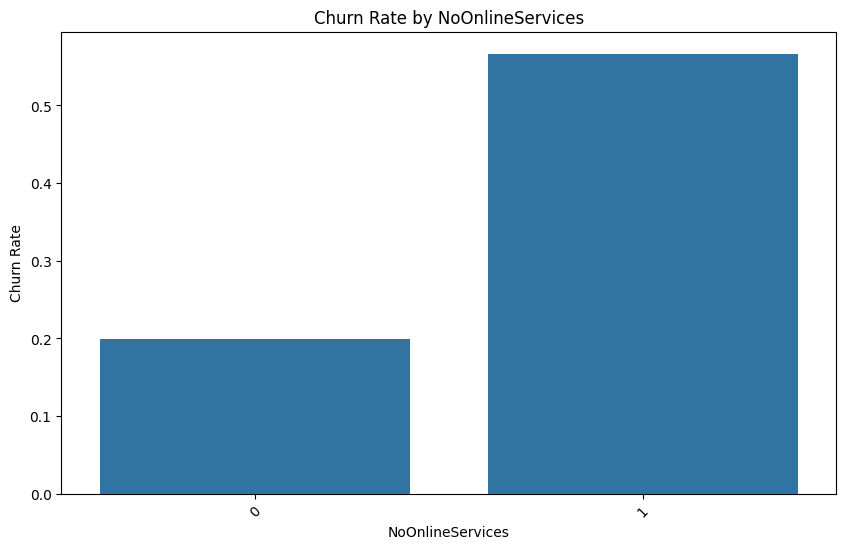

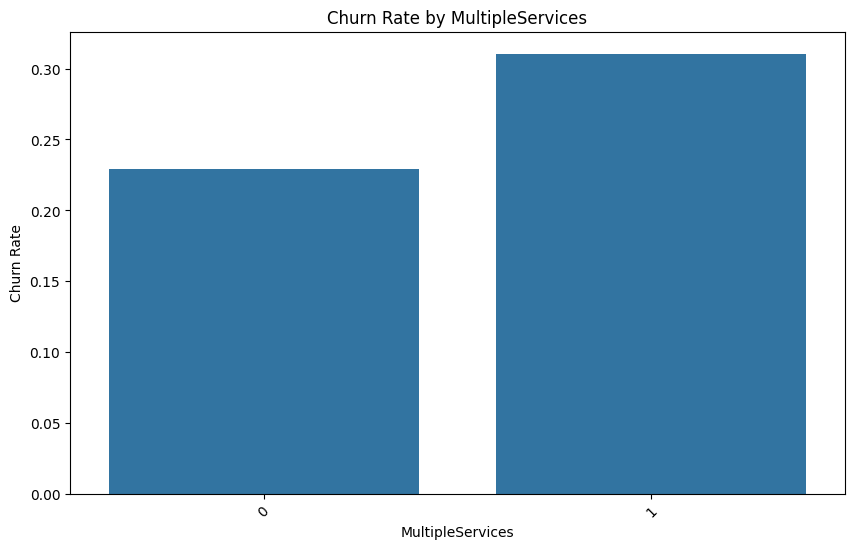

In [7]:
# Create new features based on insights from EDA
df['HighMonthlyCharge'] = (df['MonthlyCharges'] > df['MonthlyCharges'].median()).astype(int)
df['LowTenure'] = (df['tenure'] < df['tenure'].median()).astype(int)
df['NoOnlineServices'] = ((df['OnlineSecurity'] == 'No') &
                          (df['OnlineBackup'] == 'No') &
                          (df['DeviceProtection'] == 'No') &
                          (df['TechSupport'] == 'No')).astype(int)
df['MultipleServices'] = ((df['PhoneService'] == 'Yes') &
                          (df['InternetService'] != 'No') &
                          ((df['StreamingTV'] == 'Yes') |
                           (df['StreamingMovies'] == 'Yes'))).astype(int)

# Drop the temporary tenure_group column
df.drop('tenure_group', axis=1, inplace=True)

# Check the new features' relationship with churn
for new_feat in ['HighMonthlyCharge', 'LowTenure', 'NoOnlineServices', 'MultipleServices']:
    plot_churn_rate(new_feat)

In [8]:
# Split data into features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Add feature selection and SMOTE to handle class imbalance
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k='all')),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))])

In [9]:
# Define models to try
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    # Update the pipeline with current model
    pipeline.set_params(classifier=model)

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Predict on test set
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Store results
    results[name] = {
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'model': pipeline
    }

    # Print results
    print(f"\n{name} Results:")
    print("Classification Report:")
    print(results[name]['classification_report'])
    print(f"ROC-AUC Score: {results[name]['roc_auc']:.4f}")
    print("Confusion Matrix:")
    print(results[name]['confusion_matrix'])

# Select best model based on ROC-AUC
best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
best_model = results[best_model_name]['model']
print(f"\nBest model is {best_model_name} with ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")


RandomForest Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1035
           1       0.58      0.54      0.56       374

    accuracy                           0.78      1409
   macro avg       0.71      0.70      0.71      1409
weighted avg       0.77      0.78      0.77      1409

ROC-AUC Score: 0.8160
Confusion Matrix:
[[891 144]
 [172 202]]

GradientBoosting Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1035
           1       0.57      0.66      0.61       374

    accuracy                           0.78      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.79      0.78      0.78      1409

ROC-AUC Score: 0.8415
Confusion Matrix:
[[847 188]
 [127 247]]

LogisticRegression Results:
Classification Report:
              precision    recall  f1-score   support

           0     

In [12]:
# First, let's verify which model we're working with
print(f"Best model selected for tuning: {best_model_name}")

# Define separate parameter grids for each model type
param_grids = {
    'RandomForest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2]
    },
    'GradientBoosting': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__max_depth': [3, 5],
        'classifier__min_samples_split': [2, 5]
    },
    'LogisticRegression': {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs', 'liblinear']
    }
}

# Select the appropriate parameter grid
if best_model_name in param_grids:
    param_grid = param_grids[best_model_name]
    print(f"\nSelected parameter grid for {best_model_name}:")
    print(param_grid)

    try:
        # Temporarily set n_jobs=1 to avoid parallel processing issues
        grid_search = GridSearchCV(
            best_model,
            param_grid,
            cv=5,
            scoring='roc_auc',
            n_jobs=1,  # Reduced to 1 for stability
            verbose=1
        )

        print("\nStarting grid search...")
        grid_search.fit(X_train, y_train)

        # Get best estimator
        tuned_model = grid_search.best_estimator_

        # Evaluate tuned model
        y_pred_tuned = tuned_model.predict(X_test)
        y_proba_tuned = tuned_model.predict_proba(X_test)[:, 1]

        print("\nTuned Model Results:")
        print("Best Parameters:", grid_search.best_params_)
        print("Classification Report:")
        print(classification_report(y_test, y_pred_tuned))
        print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_tuned):.4f}")
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred_tuned))

    except Exception as e:
        print(f"\nError during grid search for {best_model_name}: {str(e)}")
        print("Using untuned model as fallback")
        tuned_model = best_model
        y_pred_tuned = tuned_model.predict(X_test)
        y_proba_tuned = tuned_model.predict_proba(X_test)[:, 1]

        print("\nUntuned Model Results:")
        print("Classification Report:")
        print(classification_report(y_test, y_pred_tuned))
        print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_tuned):.4f}")
else:
    print(f"\nNo parameter grid defined for {best_model_name}")
    print("Using untuned model")
    tuned_model = best_model


Best model selected for tuning: GradientBoosting

Selected parameter grid for GradientBoosting:
{'classifier__n_estimators': [100, 200], 'classifier__learning_rate': [0.05, 0.1], 'classifier__max_depth': [3, 5], 'classifier__min_samples_split': [2, 5]}

Starting grid search...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Error during grid search for GradientBoosting: Invalid parameter 'learning_rate' for estimator LogisticRegression(max_iter=1000, random_state=42). Valid parameters are: ['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'].
Using untuned model as fallback

Untuned Model Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macr


Model Interpretation:
Classifier type: LogisticRegression

Logistic regression interpretation:


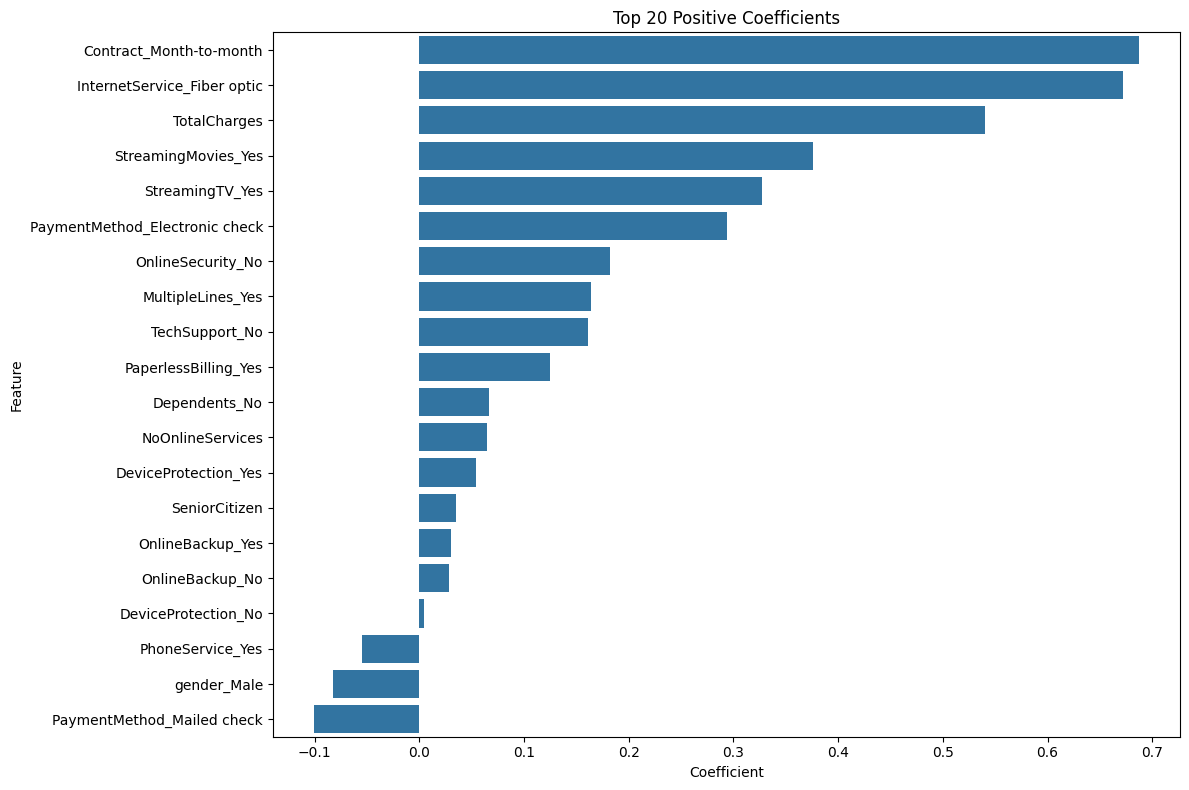

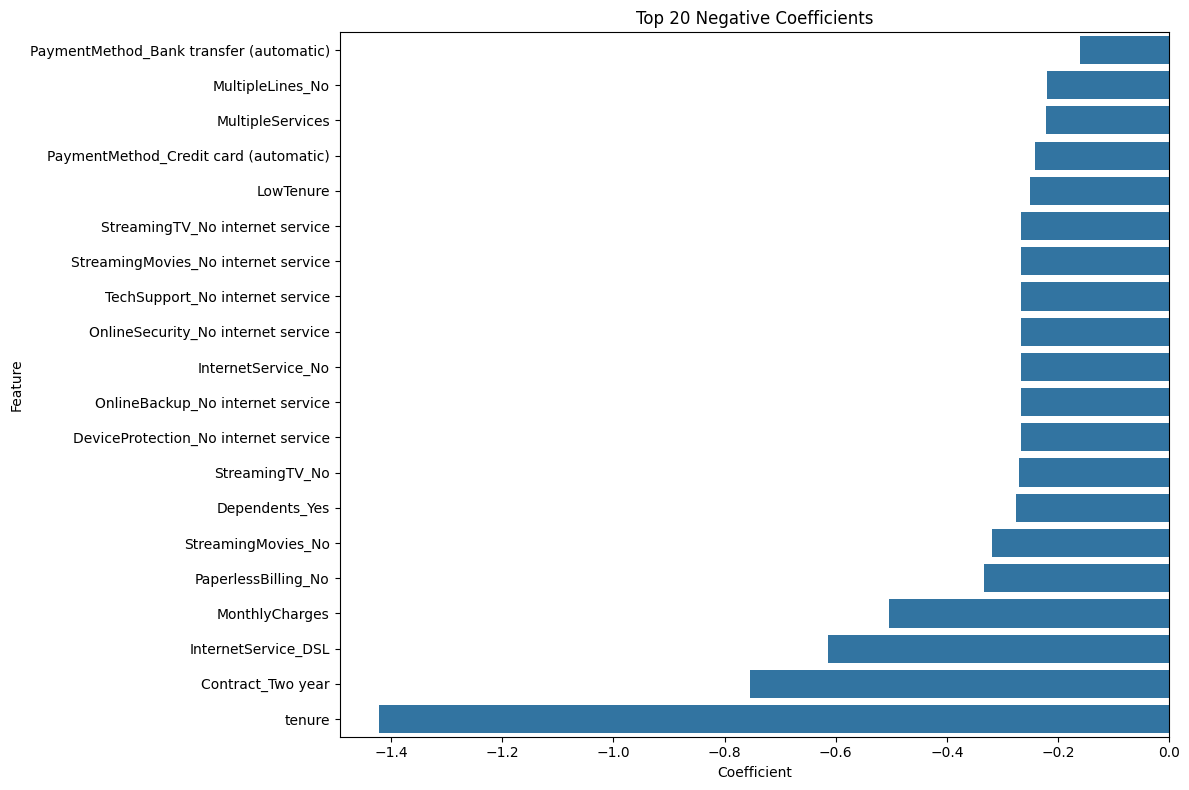

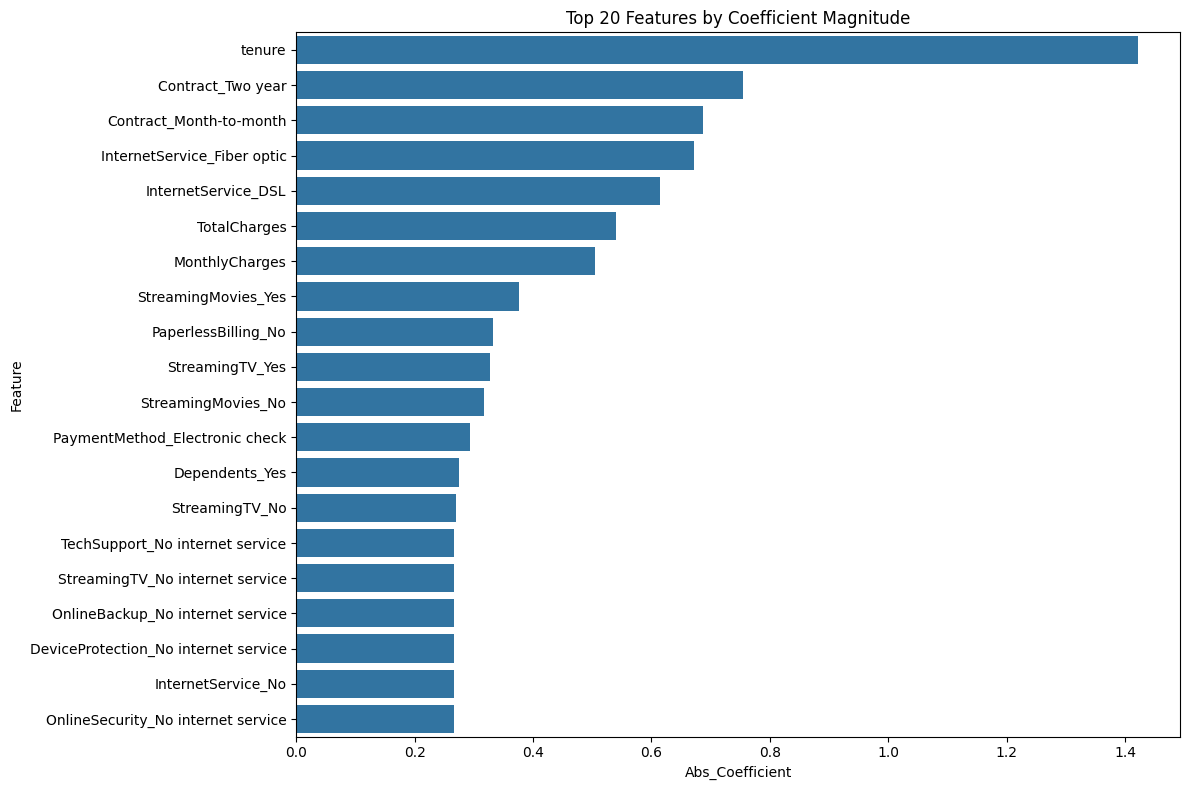


Partial Dependence Plots:
Creating PDP for: ['tenure', 'MonthlyCharges', 'TotalCharges']


<Figure size 800x500 with 0 Axes>

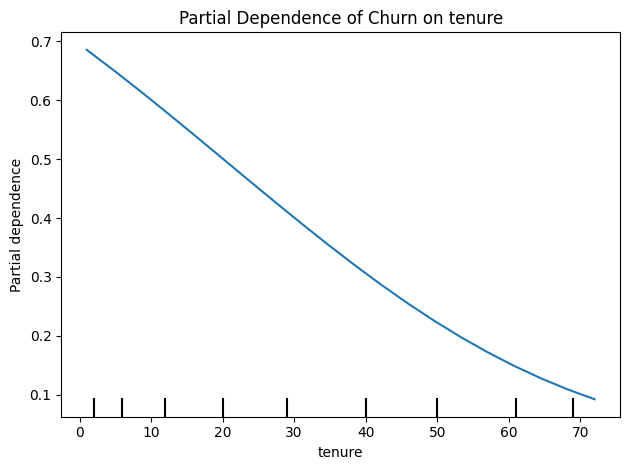

<Figure size 800x500 with 0 Axes>

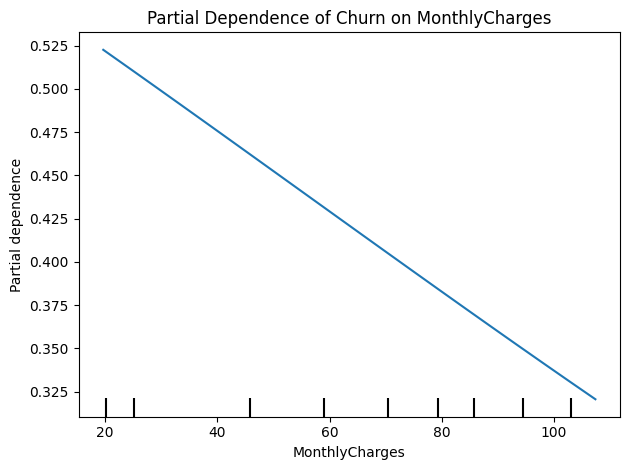

<Figure size 800x500 with 0 Axes>

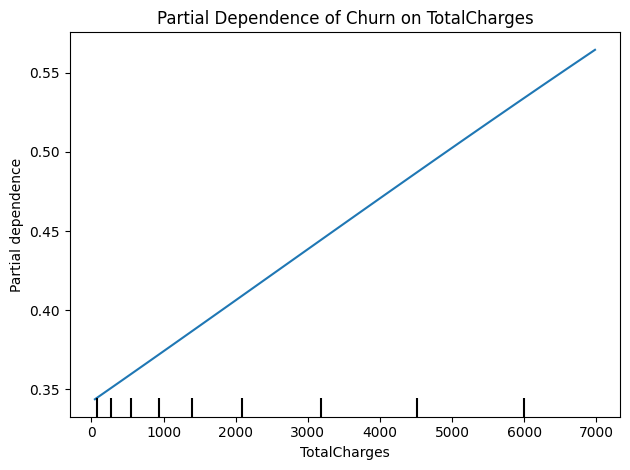


ICE Plot for Tenure (Individual Conditional Expectation):


<Figure size 1000x600 with 0 Axes>

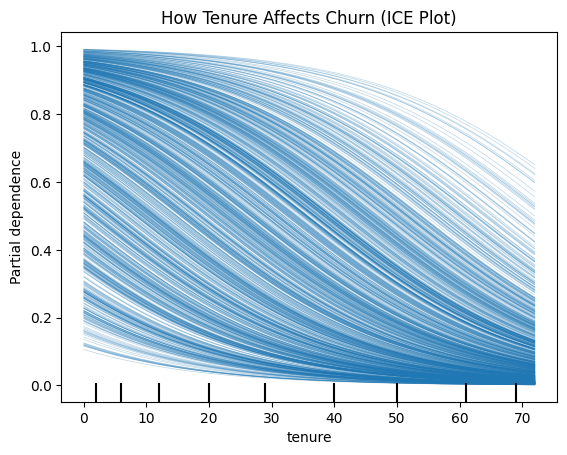

In [17]:
# Model Interpretation
print("\nModel Interpretation:")

# First, get the classifier step from the pipeline
classifier = tuned_model.named_steps['classifier']
classifier_type = type(classifier).__name__
print(f"Classifier type: {classifier_type}")

# Get preprocessed data and feature names
preprocessed_data = tuned_model.named_steps['preprocessor'].transform(X_train)
onehot_columns = tuned_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = numerical_features + list(onehot_columns)

# Create a dictionary to map feature names to their importance/coefficients
if classifier_type in ['RandomForestClassifier', 'GradientBoostingClassifier']:
    print("\nTree-based model interpretation:")

    # Feature importance
    importances = classifier.feature_importances_
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importance_df = importance_df.sort_values('Importance', ascending=False)

    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 Features by Importance')
    plt.tight_layout()
    plt.show()

    # Try SHAP explanation if it's a tree-based model
    try:
        import shap
        print("\nAttempting SHAP explanation...")

        # Use KernelExplainer as a more general approach
        def model_predict(data):
            return classifier.predict_proba(data)

        explainer = shap.KernelExplainer(model_predict, preprocessed_data[:100])
        shap_values = explainer.shap_values(preprocessed_data[:100])

        # Summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, preprocessed_data[:100], feature_names=feature_names)
        plt.title('SHAP Summary Plot')
        plt.show()

    except Exception as e:
        print(f"Could not create SHAP explanation: {str(e)}")

elif classifier_type == 'LogisticRegression':
    print("\nLogistic regression interpretation:")

    # Get coefficients
    coefficients = classifier.coef_[0]
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
    coef_df = coef_df.sort_values('Coefficient', ascending=False)

    # Plot coefficients
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(20))
    plt.title('Top 20 Positive Coefficients')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df.tail(20))
    plt.title('Top 20 Negative Coefficients')
    plt.tight_layout()
    plt.show()

    # Plot coefficient magnitudes
    coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Abs_Coefficient', y='Feature', data=coef_df.head(20))
    plt.title('Top 20 Features by Coefficient Magnitude')
    plt.tight_layout()
    plt.show()

else:
    print(f"\nInterpretation not implemented for {classifier_type}")

# Partial Dependence Plots - Fixed Implementation
print("\nPartial Dependence Plots:")

# Select numerical features (PDP works best with continuous variables)
numerical_for_pdp = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Ensure they exist in the dataset
valid_features = [f for f in numerical_for_pdp if f in X_train.columns]

if valid_features:
    print(f"Creating PDP for: {valid_features}")

    # Plot PDP for each numerical feature (one at a time)
    for feature in valid_features[:3]:  # Limit to 3 features
        plt.figure(figsize=(8, 5))
        try:
            PartialDependenceDisplay.from_estimator(
                tuned_model,
                X_train,
                features=[feature],
                feature_names=X_train.columns.tolist(),
                kind='average',  # Show average effect
                grid_resolution=20  # Smooth curves
            )
            plt.title(f'Partial Dependence of Churn on {feature}')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Could not plot PDP for {feature}: {str(e)}")
else:
    print("No suitable numerical features found for PDP")

# Alternative: ICE Plots for key features (shows individual variations)
if 'tenure' in X_train.columns:
    print("\nICE Plot for Tenure (Individual Conditional Expectation):")
    plt.figure(figsize=(10, 6))
    PartialDependenceDisplay.from_estimator(
        tuned_model,
        X_train,
        features=['tenure'],
        kind='individual',  # Show individual lines
        ice_lines_kw={'alpha': 0.3, 'linewidth': 0.5},
        feature_names=X_train.columns.tolist()
    )
    plt.title('How Tenure Affects Churn (ICE Plot)')
    plt.show()

In [19]:
# Updated prediction function that includes feature engineering
def predict_churn(customer_data, model, metadata):
    """
    Function to predict churn for new customer data
    customer_data: Dictionary of customer features
    model: Trained pipeline model
    metadata: Model metadata with feature information
    """
    # Convert to DataFrame
    input_data = pd.DataFrame([customer_data])

    # Ensure correct data types
    for num_col in metadata['numerical_features']:
        if num_col in input_data.columns:
            input_data[num_col] = pd.to_numeric(input_data[num_col], errors='coerce')

    # Add engineered features (same as during training)
    input_data['HighMonthlyCharge'] = (input_data['MonthlyCharges'] > input_data['MonthlyCharges'].median()).astype(int)
    input_data['LowTenure'] = (input_data['tenure'] < input_data['tenure'].median()).astype(int)
    input_data['NoOnlineServices'] = ((input_data['OnlineSecurity'] == 'No') &
                                    (input_data['OnlineBackup'] == 'No') &
                                    (input_data['DeviceProtection'] == 'No') &
                                    (input_data['TechSupport'] == 'No')).astype(int)
    input_data['MultipleServices'] = ((input_data['PhoneService'] == 'Yes') &
                                    (input_data['InternetService'] != 'No') &
                                    ((input_data['StreamingTV'] == 'Yes') |
                                     (input_data['StreamingMovies'] == 'Yes'))).astype(int)

    # Predict
    churn_prob = model.predict_proba(input_data)[0, 1]
    churn_pred = model.predict(input_data)[0]

    return {
        'churn_probability': float(churn_prob),
        'churn_prediction': bool(churn_pred),
        'risk_category': 'High' if churn_prob > 0.7 else 'Medium' if churn_prob > 0.3 else 'Low'
    }

# Test the prediction function with corrected customer data
test_customer = {
    'gender': 'Male',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 12,
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'DSL',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'No',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 75.0,
    'TotalCharges': 900.0
}

print("\nExample Prediction:")
print(predict_churn(test_customer, tuned_model, model_metadata))


Example Prediction:
{'churn_probability': 0.7144706979536034, 'churn_prediction': True, 'risk_category': 'High'}
